# Real esate advertisement

In [1]:
import hashlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold

### Random seed Neptun kód alapján

Prompt: Generate random seed based on my Neptun code

In [2]:
neptun = "JPWF8N"
seed = int(hashlib.sha256(neptun.encode("utf-8")).hexdigest(), 16) % 10**8
print(f"Random seed based on NEPTUN code: {seed}")

Random seed based on NEPTUN code: 75628879


## Adatfeldolgozas

In [3]:
df = pd.read_csv("../data/ingatlan.csv")
cols_shuffled = np.random.RandomState(seed).permutation(df.columns)
df = df[cols_shuffled]
df.describe()

,ad_view_cnt,nr,balcony_area,price_created_at,postcode,active_days,district,property_area,small_room_cnt,room_cnt
count,183564.000000,183565.000000,175966.000000,183565.000000,115475.000000,183565.000000,176009.000000,183565.000000,182981.000000,183565.000000
mean,262.264082,196659.747942,7.748792,20.564001,1103.395895,44.071593,9.730434,48.443984,0.547177,1.476393
std,556.838684,113179.241269,2360.665258,171.496565,50.789818,47.969011,4.782807,12.776044,0.748810,0.972892
min,0.000000,7.000000,0.000000,0.000000,1011.000000,1.000000,1.000000,0.000000,-1.000000,0.000000
25%,41.000000,98117.000000,0.000000,13.200000,1063.000000,11.000000,6.000000,40.000000,0.000000,1.000000
50%,102.000000,196774.000000,0.000000,16.900000,1101.000000,28.000000,10.000000,50.000000,0.000000,1.000000
75%,265.000000,294824.000000,3.000000,23.900000,1141.000000,60.000000,13.000000,60.000000,1.000000,2.000000
max,40248.000000,394178.000000,990257.000000,41796.000000,1239.000000,544.000000,20.000000,70.000000,56.000000,215.000000


In [4]:
df_raw = df.copy()

### Függények adatfeldolgozáshoz

prompt: Create function to remove outliers

In [46]:
def remove_outliers_iqr(df, column='price_created_at', lower_thresh=1_000_000, upper_thresh=500_000_000, factor=1.5):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_iqr = q1 - factor * iqr
    upper_iqr = q3 + factor * iqr

    lower = max(lower_iqr, lower_thresh)
    upper = min(upper_iqr, upper_thresh)

    df_filtered = df[(df[column] >= lower) & (df[column] <= upper)]
    return df_filtered


prompt: Create parser for the building floors, that can have the following values: 1-10, more than 10, missing

In [6]:
def building_floor_count_parser(value):
    # distinct values are: 1-10, more than 10, nan
    if pd.isna(value):
        return np.nan

    value = str(value).strip().lower()

    if "more" in value and "10" in value:
        return 11
    else:
        try:
            return int(value)
        except ValueError:
            return np.nan

prompt: Create parser for the floor umber that can be the following 1-10, 10 plus, ground floor, mezzanine floor, 10 plus

In [7]:
def floor_parser(val):
    if pd.isna(val):
        return np.nan

    val = str(val).strip().lower()

    if "basement" in val:
        return -1
    elif "ground" in val:
        return 0
    elif "mezzanine" in val:
        return 0.5
    elif "plus" in val:
        nums = [int(s) for s in val.split() if s.isdigit()]
        return nums[0] + 1 if nums else 11
    else:
        try:
            return int(val)
        except ValueError:
            return np.nan

In [8]:
df_orientation = df['orientation'].copy()
df_heating_type = df['heating_type'].copy()
df_property_condition_type = df['property_condition_type'].copy()
df_property_floor = df['property_floor'].copy()

df_orientation_raw = df_orientation.copy()
df_heating_type_raw = df_orientation.copy()
df_property_condition_type_raw = df_orientation.copy()
df_property_floor_raw = df_orientation.copy()

Getting unique values for the prompt 

In [9]:
print("Orientation unique values:")
print(df_orientation.unique())
print("Heating type unique values:")
print(df_heating_type.unique())
print("Property condition type unique values:")
print(df_property_condition_type.unique())
print("Property floor unique values:")
print(df_property_floor.unique())

Orientation unique values:
['east' nan 'west' 'south-east' 'south-west' 'north-east' 'north-west'
 'south' 'north']
Heating type unique values:
[nan 'gas furnace, circulating hot water' 'konvection gas burner'
 'district heating' 'central heating with own meter' 'tile stove (gas)'
 'central heating' 'electric' 'other' 'fan-coil' 'gas furnace'
 'gas + solar']
Property condition type unique values:
['good' 'novel' 'medium' 'renewed' 'new_construction' 'to_be_renovated'
 'can_move_in' 'missing_info' 'under_construction']
Property floor unique values:
['3' 'ground floor' '4' 'basement' '7' '2' '1' nan 'mezzanine floor' '8'
 '6' '10' '5' '9' '10 plus']


Encoding methods

prompt: Generate encoding methods based on the following available unique values: ...

In [10]:
def encode_orientation_method1(df):
    # ordinal encoding based on sunlight exposure levels
    # south = best, north = worst
    mapping = {
        'missing': 0,
        'north': 1,
        'north-east': 2,
        'east': 3,
        'south-east': 4,
        'south': 5,
        'south-west': 4,
        'west': 3,
        'north-west': 2
    }
    return df.map(mapping).fillna(0).astype(int)

def encode_orientation_method2(df):
    # onehot encoding
    return pd.get_dummies(df.fillna('missing'), prefix='orientation')


In [11]:
def encode_heating_method1(df):
    # ordinal encoding based on heating efficiency and cost
    mapping = {
        'missing': 0,
        'tile stove (gas)': 1,
        'konvection gas burner': 2,
        'gas furnace': 3,
        'gas furnace, circulating hot water': 3,
        'central heating': 4,
        'central heating with own meter': 5,
        'district heating': 6,
        'fan-coil': 7,
        'electric': 8,
        'other': 0      
    }
    return df.map(mapping).fillna(0).astype(int)

def encode_heating_method2(df):
    # onehot encoding
    return pd.get_dummies(df.fillna('missing'), prefix='heating')


In [12]:
def encode_condition_method1(df):
    # ordinal encoding — based on condition quality progression.
    mapping = {
        'missing_info': 0,
        'to_be_renovated': 1,
        'medium': 2,
        'good': 3,
        'can_move_in': 4,
        'renewed': 5,
        'novel': 6,
        'under_construction': 7,
        'new_construction': 8
    }
    return df.map(mapping).fillna(0).astype(int)

def encode_condition_method2(df):
    # onehot encoding
    return pd.get_dummies(df.fillna('missing_info'), prefix='condition')

In [13]:
def encode_floor_method1(df):
    # Direct numeric usage with missing values filled.
    return df.fillna(0).astype(float)

def encode_floor_method2(df):
    # Feature-engineered floor info.
    return pd.DataFrame({
        'is_basement': (df < 0).astype(int),
        'is_ground': (df == 0).astype(int),
        'is_high_floor': (df >= 8).astype(int),
        'normalized_floor': df.fillna(0) / df.max()  # relative position
    })


In [14]:
df = df_raw.copy()

### Tuning egyesevel
df['price_per_m2'] = (df['price_created_at'] / df['property_area'])*1e6
df = df[df['price_per_m2'] > 100_000]
df['price_per_m2'] = df['price_per_m2'].replace([np.inf, -np.inf], np.nan)
df['price_per_m2'] = df['price_per_m2'].fillna(df['price_per_m2'].median())
df['small_room_cnt'] = df['small_room_cnt'].fillna(0)
df['property_floor'] = df['property_floor'].apply(floor_parser)
df['building_floor_count'] = df['building_floor_count'].apply(building_floor_count_parser)
df = df[df['property_area'] > 0].copy()
df.isna().sum().sort_values(ascending=False).head(20)

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna('missing')
    else:
        df[col] = df[col].fillna(df[col].median())

# dátum konverzió
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df['month'] = df['created_at'].dt.month
df['year'] = df['created_at'].dt.year
df['day'] = df['created_at'].dt.day
df = df.drop(columns=['created_at'])

# felesleges oszlopok kidobasa
df.drop(columns=['ad_view_cnt', 'active_days', 'nr', 'county','property_type','city'], inplace=True)


In [15]:
df.drop(columns=['view_type', 'property_subtype', 'elevator_type', 'garden_access'], inplace=True)

Configurable columns:

In [16]:
df_orientation = df['orientation'].copy()
df_heating_type = df['heating_type'].copy()
df_property_condition_type = df['property_condition_type'].copy()
df_property_floor = df['property_floor'].copy()

In [17]:
df_other = df.drop(columns=['orientation', 'heating_type', 'property_condition_type', 'property_floor'])

In [18]:
df_other.drop(columns='price_per_m2')

,balcony_area,price_created_at,postcode,building_floor_count,district,property_area,small_room_cnt,room_cnt,month,year,day
0,0.0,9.5,1101.0,10.0,4.0,35.0,1.0,1.0,2,2015,9
1,0.0,11.2,1147.0,4.0,14.0,35.0,0.0,1.0,2,2015,9
2,0.0,14.5,1101.0,4.0,14.0,50.0,0.0,2.0,2,2015,9
3,0.0,15.3,1024.0,4.0,2.0,50.0,1.0,1.0,2,2015,9
4,0.0,17.9,1126.0,4.0,12.0,50.0,2.0,1.0,2,2015,9
...,...,...,...,...,...,...,...,...,...,...,...
183560,0.0,11.0,1076.0,4.0,7.0,30.0,0.0,1.0,8,2016,29
183561,0.0,20.5,1101.0,4.0,7.0,45.0,0.0,2.0,8,2016,29
183562,0.0,8.5,1101.0,1.0,4.0,40.0,0.0,1.0,8,2016,29
183563,4.0,18.9,1101.0,4.0,4.0,65.0,1.0,2.0,8,2016,29


In [19]:
print(df_orientation.shape)
print(df_other.shape)

(183367,)
(183367, 12)


In [20]:
configs = list(itertools.product(
    ['method1', 'method2'],  # orientation
    ['method1', 'method2'],  # heating
    ['method1', 'method2'],  # condition
    ['method1', 'method2']   # floor
))

In [21]:
# orientation_method = 'method1'
# heating_method = 'method1'
# cond_method = 'method1'
# floor_method = 'method1'
# X_parts = [
#    df_other,
#    eval(f"encode_orientation_{orientation_method}(df_orientation)"),
#    eval(f"encode_heating_{heating_method}(df_heating_type)"),
#    eval(f"encode_condition_{cond_method}(df_property_condition_type)"),
#    eval(f"encode_floor_{floor_method}(df_property_floor)")
# ]
# X_encoded = pd.concat(X_parts, axis=1)

In [22]:
# df_orientation = encode_orientation_method1(df['orientation'])
# df_heating_type = encode_heating_method1(df['heating_type'])
# df_property_condition_type = encode_condition_method1(df['property_condition_type'])
# df_property_floor = encode_floor_method1(df['property_floor'])

In [23]:
# df_orientation.describe()
# df_heating_type.describe()
# df_property_condition_type.describe()
# df_property_floor.describe()

In [24]:
# X_parts = [df_other, df_orientation, df_heating_type, df_property_condition_type, df_property_floor]
# X_encoded = pd.concat(X_parts, axis=1)
# X_encoded.info()

In [25]:
# X_encoded.describe()

In [26]:
def evaluate_config(config):
    orientation_method, heating_method, cond_method, floor_method = config

    # target valtozo
    y = df['price_per_m2'].astype(float)
    
    # konfig hasznalata    
    df_orientation = eval(f"encode_orientation_{orientation_method}(df_orientation)")
    df_heating_type = eval(f"encode_heating_{heating_method}(df_heating_type)")
    df_property_condition_type = eval(f"encode_condition_{cond_method}(df_property_condition_type)")
    df_property_floor = eval(f"encode_floor_{floor_method}(df_property_floor)")
    
    X_parts = [df_other, df_orientation, df_heating_type, df_property_condition_type, df_property_floor]

    X_encoded = pd.concat(X_parts, axis=1)
    
    # 3-as KFold cross-validation
    kf = KFold(n_splits=3, shuffle=True, random_state=seed)
    mape_scores = {'LinearRegression': [], 'GBM': []}

    for train_idx, test_idx in kf.split(X_encoded):
        X_train, X_test = X_encoded.iloc[train_idx], X_encoded.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Linear Regression
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        preds_lr = lr.predict(X_test)
        mape_scores['LinearRegression'].append(mean_absolute_percentage_error(y_test, preds_lr))

        # Gradient Boosting
        gbm = GradientBoostingRegressor(random_state=seed, n_estimators=10)
        gbm.fit(X_train, y_train)
        preds_gbm = gbm.predict(X_test)
        mape_scores['GBM'].append(mean_absolute_percentage_error(y_test, preds_gbm))

    return {
        'config': config,
        'lr_mape': np.mean(mape_scores['LinearRegression']),
        'gbm_mape': np.mean(mape_scores['GBM'])
    }


In [27]:
results = []
for cfg in configs:
    res = evaluate_config(cfg)
    results.append(res)
    print(f"{cfg} — LR MAPE: {res['lr_mape']:.20f}, GBM MAPE: {res['gbm_mape']:.20f}")

results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values('gbm_mape')

best_gbm = results_df_sorted.loc[results_df_sorted['gbm_mape'].idxmin()]
print(best_gbm)

best_lr = results_df.loc[results_df['lr_mape'].idxmin()]
print(best_lr)

('method1', 'method1', 'method1', 'method1') — LR MAPE: 0.00000000000000022366, GBM MAPE: 0.27324754324427996677
('method1', 'method1', 'method1', 'method2') — LR MAPE: 0.00000000000000033934, GBM MAPE: 0.27324740925291007843
('method1', 'method1', 'method2', 'method1') — LR MAPE: 0.00000000000000014989, GBM MAPE: 0.27324674340268267914
('method1', 'method1', 'method2', 'method2') — LR MAPE: 0.00000000000000019576, GBM MAPE: 0.27324679692878883763
('method1', 'method2', 'method1', 'method1') — LR MAPE: 0.00000000000000019892, GBM MAPE: 0.27324710239733357442
('method1', 'method2', 'method1', 'method2') — LR MAPE: 0.00000000000000018524, GBM MAPE: 0.27324686502084127859
('method1', 'method2', 'method2', 'method1') — LR MAPE: 0.00000000000000018002, GBM MAPE: 0.27324642383531533296
('method1', 'method2', 'method2', 'method2') — LR MAPE: 0.00000000000000021544, GBM MAPE: 0.27324636621175857343
('method2', 'method1', 'method1', 'method1') — LR MAPE: 0.00000000000000028397, GBM MAPE: 0.2732

### Változók szerepe a modelleken

prompt: Készíts vizaulizációt vizualizációt arra vonatkozóan, hogy mennyire segítettek az egyes változók az egyes modelleken. Ajánlj különböző plotolási módokat.

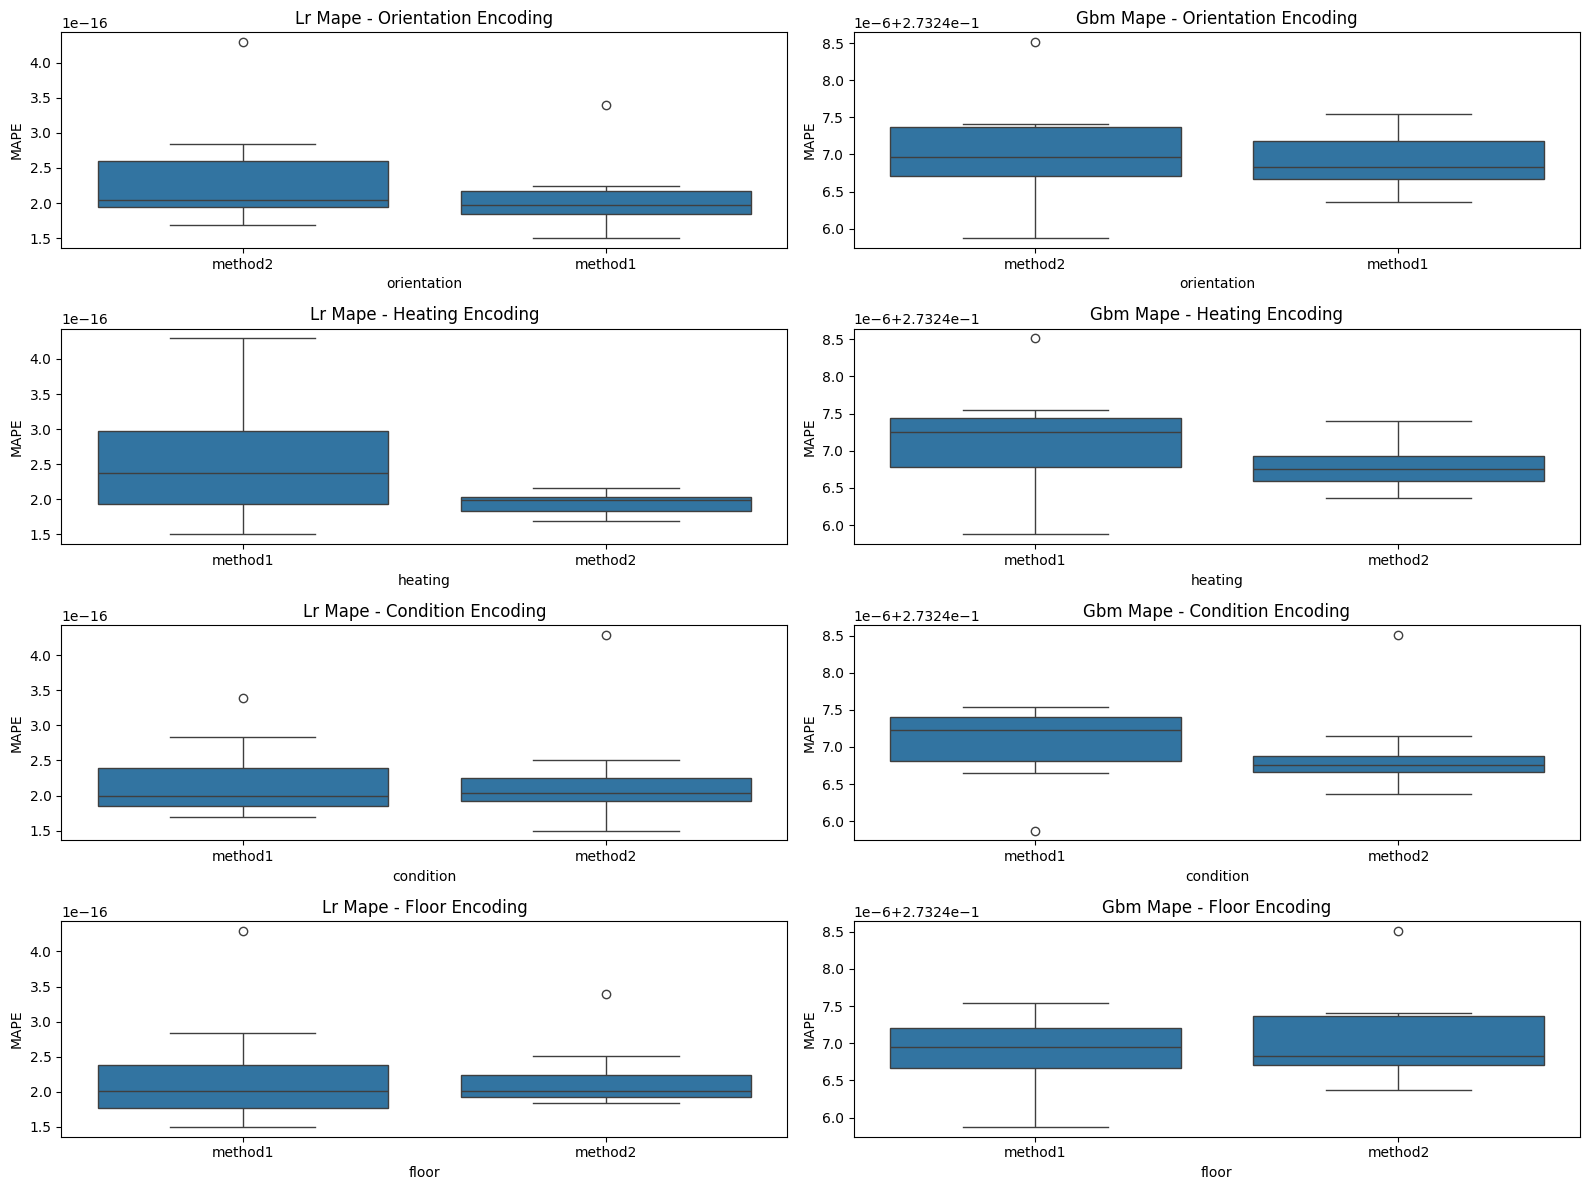

In [28]:
results_df_sorted[['orientation', 'heating', 'condition', 'floor']] = pd.DataFrame(
    results_df_sorted['config'].tolist(), index=results_df_sorted.index
)

avg_mape = results_df_sorted.groupby(['orientation', 'heating', 'condition', 'floor'])[
    ['lr_mape','gbm_mape']
].mean()

categorical_cols = ['orientation', 'heating', 'condition', 'floor']
models = ['lr_mape', 'gbm_mape']

plt.figure(figsize=(16, 12))

for i, cat_col in enumerate(categorical_cols):
    for j, model in enumerate(models):
        plt_idx = i*2 + j + 1
        plt.subplot(len(categorical_cols), 2, plt_idx)
        sns.boxplot(data=results_df_sorted, x=cat_col, y=model)
        plt.title(f"{model.replace('_',' ').title()} - {cat_col.title()} Encoding")
        plt.ylabel('MAPE')
        plt.xlabel(cat_col)

plt.tight_layout()
plt.show()

A megoldásom során a feladat által ismertetett négy változót 2 különböző enkódolási módszerrel is kipróbáltam. Jellemzően ordinal vagy one-hot encodingot alkalmaztam. Lefuttatam minden kombinációra a tanítást. Ebből az ábrán is látható eredmények adódtak.

(sorrend: orientation, heating, condition, floor)

Gradient Boosting legjobb kombináció: method1, method1, method2, method2

Lineáris Regresszió legjobb kombináció: method1, method2, method1, method2

Az egyes változókon végzett adatelőkészítési lépések folyamatosan segítették a modelleket. A megoldás során leginkább az okozott problémát amikor a négyzetméter árak során volt 0 körüli pozitív érték az adathalmazban. Ugyanis ekkor a MAPE értékék nagyon elszáltak. A kiguróan alacsony értékek levágása megoldotta a problémát.

Ami pedig az a lefutások eredményeit illeti. Lineáris regresszió esetén a MAPE értékek 0 körül mozognak, ami azért leheta mert a domináns numerikus értékek miatt a lineáris modell kb. tökéeletesen prediktál. Emellett a Gradient Boosting alapú megoldás kevésbé érzékeny a kategorikus adatokra. Mintha kevés információt szolgáltatánnak a mumerikus adatokhoz képest. Gradient Boosting esetén a MAPE végig magas maradt.

Az ábrákról még leolvasható, hogy floor két különböző enkódolása kevésbé befolyásolja a két modell eredményeit. Az orientation esetében pedig et csak a Gradient Boosting esetén mondható el. A többi esetben nagyobb eltérés figyelhető meg. Bár a lineáris regresszió végig 0 körül, míg a Gradient Boosting végig 0.27 körül mozog.

### Végső adatelemzés pipeline a legjobb kombináció alapján

In [47]:
X_parts = [df_other]
X_encoded = pd.concat(X_parts, axis=1)
y = df['price_per_m2'].astype(float)

In [30]:
y = df['price_per_m2'].astype(float)
orientation_method = 'method1'
heating_method = 'method1'
cond_method = 'method2'
floor_method = 'method2'
X_parts = [
    df_other,
    eval(f"encode_orientation_{orientation_method}(df_orientation)"),
    eval(f"encode_heating_{heating_method}(df_heating_type)"),
    eval(f"encode_condition_{cond_method}(df_property_condition_type)"),
    eval(f"encode_floor_{floor_method}(df_property_floor)")
]
X_encoded = pd.concat(X_parts, axis=1)

In [31]:
X_sample = X_encoded.iloc[:1000000]
y_sample = y.iloc[:1000000]

gbm_test = GradientBoostingRegressor(n_estimators=10, random_state=42)
gbm_test.fit(X_sample, y_sample)
print(gbm_test.predict(X_sample)[:10])

[396085.68740986 396085.68740986 396085.68740986 396085.68740986
 396085.68740986 396085.68740986 396085.68740986 396085.68740986
 396085.68740986 396085.68740986]


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

gbm = GradientBoostingRegressor(random_state=42, n_estimators=75)
gbm.fit(X_train, y_train)

preds_lr = lr.predict(X_test_scaled)
preds_gbm = gbm.predict(X_test)

df_test = X_test.copy()
df_test['actual_price_per_m2'] = y_test.values
df_test['predicted_price_per_m2'] = preds_gbm

mask_undervalued = (df_test['predicted_price_per_m2'] / df_test['actual_price_per_m2'] >= 1.05) & \
                   (df_test['predicted_price_per_m2'] / df_test['actual_price_per_m2'] <= 1.25)

df_undervalued = df_test[mask_undervalued].copy()

In [42]:
len(df_undervalued)

176

In [43]:
df_test['actual_price_per_m2'].head()

56728     316666.666667
168418    378000.000000
135428    270909.090909
170507    331111.111111
28892     440000.000000
Name: actual_price_per_m2, dtype: float64

In [44]:
df_test['predicted_price_per_m2'].head()

56728     316437.450429
168418    377899.968902
135428    269455.676092
170507    332412.468453
28892     432987.580585
Name: predicted_price_per_m2, dtype: float64

In [45]:
neptun = "JPWF8N"
output_file = f"results_{neptun}.csv"
df_undervalued.to_csv(output_file, index=False)